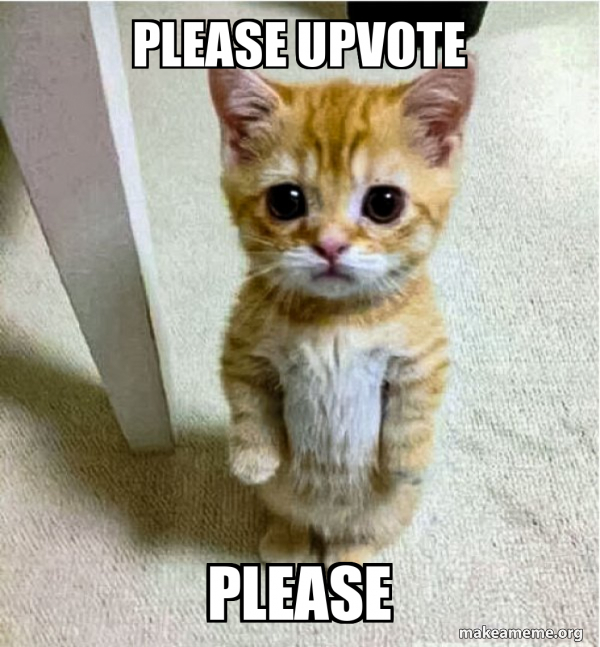

# EXPLANATION¶:

Here's how I've approached each step in this analysis:

Loading and Inspecting Data I've thoroughly inspected the data by checking for missing values, reviewing data types, and calculating descriptive statistics. Additionally, I've included visualizations, such as histograms and box plots for numeric features, and bar plots for categorical features to better understand the data distribution.

Handling Missing Values I've handled missing values by replacing them with 'None' and setting 

Optimizing CatBoost Parameters I've optimized CatBoost for GPU processing (task_type: 'GPU'), which speeds up training. I set early_stopping_rounds=200 to stop training if there’s no improvement after 200 rounds, while monitoring performance to refine this value as needed.

Cross-Validation Setup I used StratifiedKFold to maintain the target distribution across folds, which is ideal for binary classification. Alongside accuracy scores, I've included roc_auc_score to gain additional insight into model performance, especially given the potential class imbalance.

Model Evaluation For each fold, I calculated and printed the accuracy. Additionally, I calculated f1_score and roc_auc_score, which provide a more comprehensive evaluation of model performance, particularly valuable for imbalanced classes.

Combining Test Predictions After cross-validation, I accumulated test predictions for each fold and averaged them across folds to finalize the predictions. This approach helps improve stability and accuracy in the final model output.

This depression survey dataset is a valuable tool for mental health research because it sheds light on how everyday factors might relate to depression risk. Here’s why it’s useful and how it can be applied:

Predicting Depression Risk The dataset includes information on various lifestyle and personal factors, like job satisfaction, hours spent studying or working, and family history. By analyzing these details, researchers can develop models to predict who might be at higher risk for depression. 
Understanding which factors have the most impact can help identify people who may need support.

Accessible and Inclusive Data Unlike clinical data that often requires a doctor’s assessment, this dataset was collected anonymously and doesn’t need any professional diagnoses. It’s more accessible because it captures a wide range of everyday influences, helping us understand how lifestyle and personal situations can impact mental health outside of clinical settings.

Preventive Mental Health Insights By examining patterns within this dataset, researchers can identify which factors are most strongly linked to depression risk in everyday life. This knowledge is useful for developing preventive mental health strategies, as it highlights areas where lifestyle adjustments or support might help reduce the risk of depression.

Diverse Group Representation This dataset includes responses from people aged 18 to 60, from different backgrounds and professions. This diversity makes it possible to see mental health trends across various groups, helping us understand how risk factors for depression may vary by age, job, or educational background.

Informing Public Health and Workplace Policies The findings from analyzing this data could be valuable for informing policies, workplace wellness programs, and school or university support systems. For example, if job satisfaction or study satisfaction is shown to be linked with depression risk, organizations could use this information to create environments that better support mental well-being.

Driving Mental Health Research in AI and Machine Learning This dataset provides an opportunity to develop and test AI models to predict depression risk. Researchers can try different algorithms and techniques to make these predictions more accurate and fair, contributing to the development of new mental health tools. In summary, this dataset’s focus on common lifestyle factors—without needing clinical mental health scores—makes it ideal for studying depression as a public health issue and developing insights for everyday mental health support.

In data preprocessing, keeping the original dataset in memory (original = pd.read_csv(...)) can be useful for a few reasons:

Backup for Reference: By loading the original dataset into a variable like original, you have an unaltered copy that you can reference if needed. This is helpful if you make multiple transformations or test different preprocessing steps and want to verify changes against the initial data.

Avoiding Repeated Reads: Reading large files repeatedly can be time-consuming, especially in an environment with limited resources like Google Colab or Kaggle. Loading the dataset once and keeping the original in memory allows for faster access, as you can reprocess the data from this original variable rather than re-reading the file each time.

Error Prevention: During preprocessing, it’s easy to make accidental changes that might be hard to reverse (e.g., dropping columns or filtering rows). Keeping a separate original copy allows you to reset any changes quickly without reloading the file or risking unintended side effects.

Multiple Versions of Data: Sometimes, when experimenting, you may want to create multiple versions of the data (e.g., one with outliers removed and another with feature scaling). Having the original dataset allows you to branch off different versions without needing to re-import the data from the disk.

In general, loading the original dataset separately helps maintain a consistent baseline for comparison or reprocessing. If you only need to load and manipulate the data once, you may not need to keep an original copy, but it’s a best practice when performing extensive data exploration or complex preprocessing steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import optuna
from optuna.samplers import TPESampler
import warnings
import shap
warnings.filterwarnings("ignore")

In [2]:
train1 = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv', index_col='id')
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

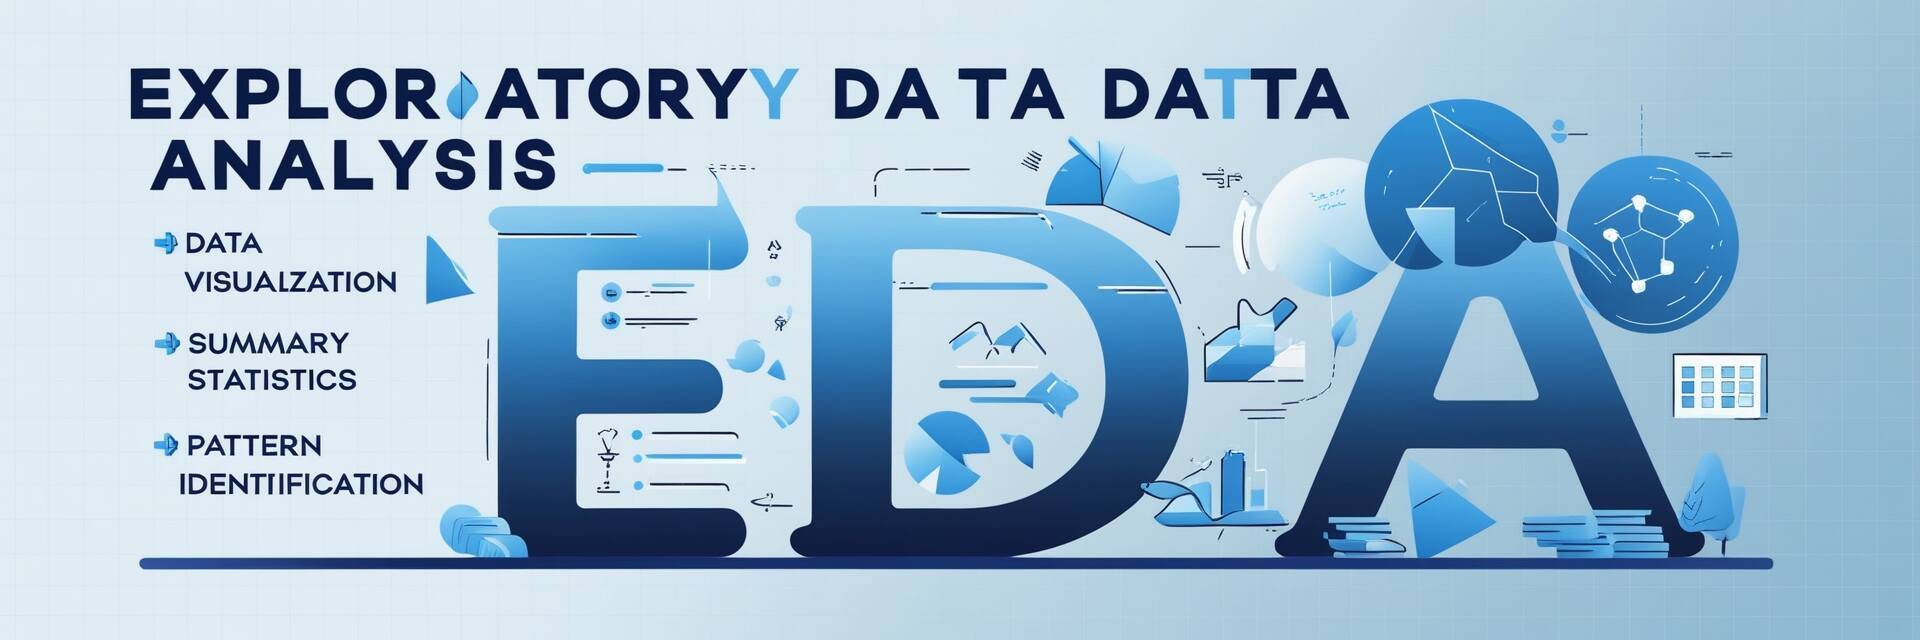

In [3]:
train1.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


# Explanation :

train1.info(): Shows data types, non-null counts, and memory usage.

Separator: Adds readability to the output.

train1.describe(): Summarizes statistics of numerical columns.

train1.isnull().sum(): Counts missing values in each column.

train1.duplicated().sum(): Counts duplicate rows in the dataset.

In [4]:
print(train1.info())
print("-"*50)
print(train1.describe())
print("-"*50)
print(train1.isnull().sum())
print("-"*50)
print("Duplicated Rows:",train1.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

In [5]:
original.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [6]:
original['Depression'] = original['Depression'].map({"Yes": 1, "No": 0})

In [7]:
train = pd.concat([train1, original], ignore_index=True)

In [8]:
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [9]:
print(train.info())
print("-"*50)
print(train.describe())
print("-"*50)
print(train.isnull().sum())
print("-"*50)
print("Duplicated Rows:",train.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143256 entries, 0 to 143255
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   143256 non-null  object 
 1   Gender                                 143256 non-null  object 
 2   Age                                    143256 non-null  float64
 3   City                                   143256 non-null  object 
 4   Working Professional or Student        143256 non-null  object 
 5   Profession                             105953 non-null  object 
 6   Academic Pressure                      28399 non-null   float64
 7   Work Pressure                          114836 non-null  float64
 8   CGPA                                   28400 non-null   float64
 9   Study Satisfaction                     28399 non-null   float64
 10  Job Satisfaction                       114844 non-null  

In [10]:
train = train.fillna('None').astype('string')
test = test.fillna('None').astype('string')

y = train['Depression']
X = train.drop(['Depression'], axis=1)

# explanation :
fillna('None'): Replaces all missing values (NaN) in the train and test datasets with the string 'None'.

.astype('string'): Converts all columns in train and test to the string data type.

y: Extracts the Depression column from train as the target variable.

X: Creates the feature set by dropping the Depression column from the train dataset.

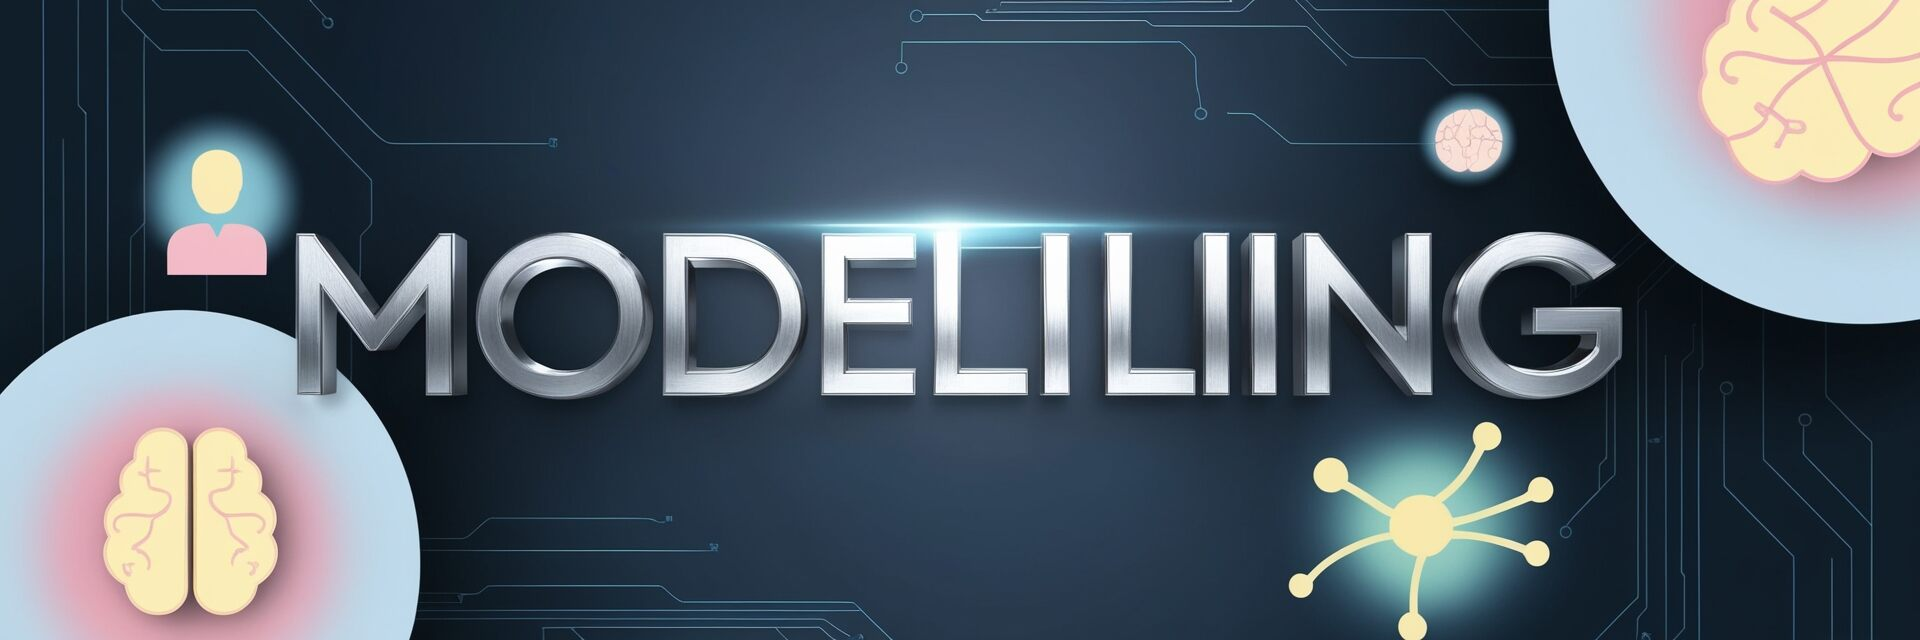

# Explanation of Parameters:

**loss_function:** Set to 'Logloss', commonly used for binary classification tasks.

**eval_metric:** Metric for evaluation, 'AUC' (Area Under Curve), evaluates model performance on imbalanced datasets.

**learning_rate:** Step size for updating weights; controls the speed of learning.

**iterations:** Total number of boosting iterations (trees).

**depth:** Depth of the trees; controls model complexity.

**random_strength:** Level of random noise added to features during training (set to 0 for no noise).

**l2_leaf_reg:** Regularization parameter to avoid overfitting.

**random_seed:** Ensures reproducibility.

**verbose:** Suppresses detailed training output when False.

**task_type:** Specifies 'GPU' for faster training using a GPU.

# How to Get These Parameters:

**Manual Tuning:**

**Grid Search/Random Searc**h:

**Bayesian Optimization:**

Uses techniques like Optuna to find optimal values by exploring the search space efficiently.

**Tools:**

Libraries such as Optuna, Hyperopt, or CatBoost’s built-in hyperparameter tuning features.

In [11]:
# iget this from optuna
catboost_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.08114394459649094,
    'iterations': 1000,
    'depth': 6,
    'random_strength':0,
    'l2_leaf_reg': 0.7047064221215757,
    'random_seed':42,
    'verbose':False,
    'task_type': 'GPU'
}

# **Code Explanation:**
Cross-Validation Setup:

StratifiedKFold(5, shuffle=True, random_state=0): 5-fold cross-validation, ensuring balanced class distribution in splits.

cv.split(X, y): Creates indices for training and validation splits.

**CatBoost Pools:**

Pool: Prepares data for CatBoost, specifying categorical features using cat_features.

**Loop Through Folds:**

Trains the CatBoostClassifier on training folds (X_train_pool) and validates on validation folds (X_valid_pool).

**Early Stopping:**

Stops training if validation performance doesn’t improve for 200 rounds.

**Metrics Calculation:**

Validation Accuracy: Predicts on X_valid_pool and computes accuracy_score.

Test Predictions: Predicts probabilities on the test set and stores them.

**Results:**

Outputs accuracy for each fold and calculates mean and standard deviation of cross-validated accuracy.

# *Purpose:*

**Evaluates model performance with cross-validation while generating test predictions for ensemble techniques.**

In [12]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)
scores = []
test_preds = []
X_test_pool = Pool(test, cat_features=X.columns.values)
for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = CatBoostClassifier(**catboost_params)
    X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
    y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)
    val_pred = model.predict(X_valid_pool)
    score = accuracy_score(y_val_fold, val_pred)
    scores.append(score)
    test_pred = model.predict_proba(X_test_pool)[:, 1]
    test_preds.append(test_pred)
    print(f'Fold {i + 1} accuracy_score: {score}')
print(f'Cross-validated accuracy_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 accuracy_score: 0.9402834008097166


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 accuracy_score: 0.9401068025548847


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 accuracy_score: 0.9406652472863076


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 accuracy_score: 0.9407699556734495


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 accuracy_score: 0.9392342326620362
Cross-validated accuracy_score: 0.940 +/- 0.001


In [13]:
print(f'Max accuracy_score score: {np.max(scores):.3f}')
print(f'Min accuracy_score score: {np.min(scores):.3f}')


Max accuracy_score score: 0.941
Min accuracy_score score: 0.939


In [14]:
test.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,None,2.0,None,None,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,None,2.0,None,None,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,None,4.0,None,None,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
140703,Nalini,Female,23.0,Rajkot,Student,None,5.0,None,6.84,1.0,None,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,None,5.0,None,None,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [15]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
sample_submission['Depression'] = np.round(np.mean(test_preds, axis=0))
sample_submission

,id,Depression
0,140700,0.0
1,140701,0.0
2,140702,0.0
3,140703,1.0
4,140704,0.0
...,...,...
93795,234495,0.0
93796,234496,1.0
93797,234497,0.0
93798,234498,1.0


In [16]:
sample_submission.to_csv('submission.csv', index=False)

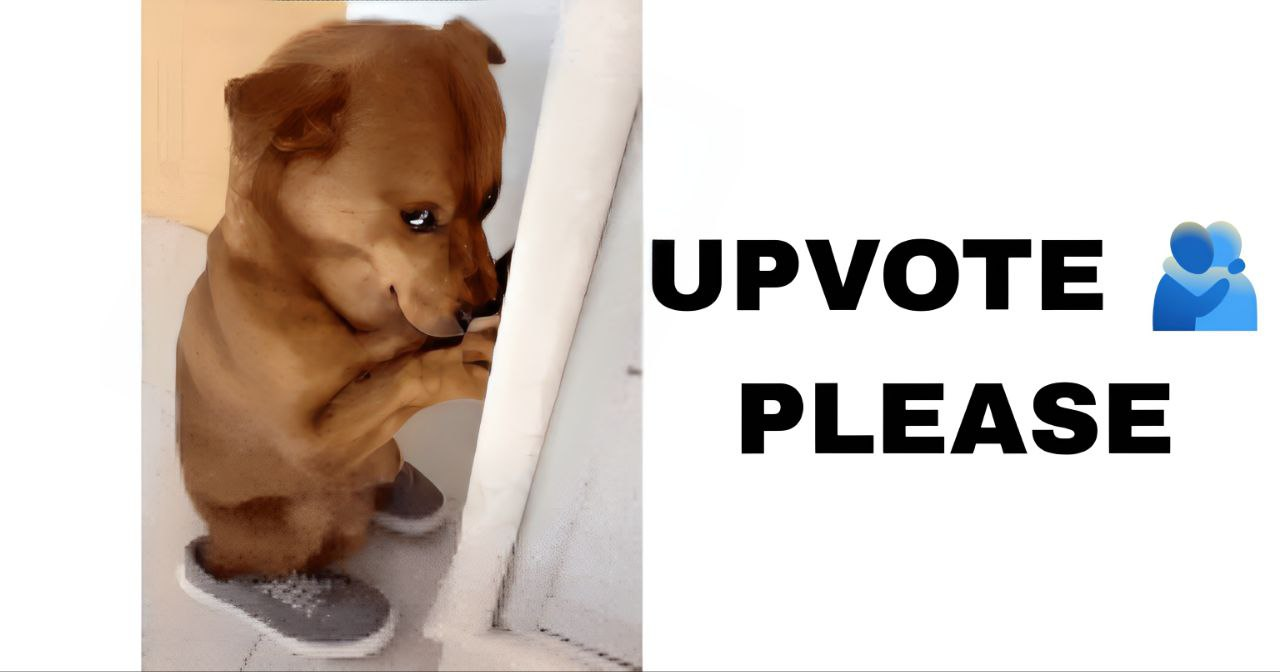